In [21]:
import math
import csv
from numpy import genfromtxt
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import pandas as pd

%matplotlib inline
np.random.seed(1)

In [22]:
# the original dataset as numpy matrix 
XY_orig=genfromtxt('train.csv', delimiter=',') 
XY_orig=np.matrix(XY_orig)   

# taking out the X portion
X_orig=XY_orig[1:39001, 0:21].T   
X_orig_max = X_orig.max(1)          
X_orig=X_orig/X_orig_max
print ("X_orig shape: " + str(X_orig.shape))

# taking out the Y portion
Y_orig=XY_orig[1:39001, 21].T       

# training set
X_train=X_orig[:, 0:36000]          
Y_train=Y_orig[:, 0:36000]          

# test set
X_test=X_orig[:, 36000:39000]       
Y_test=Y_orig[:, 36000:39000]       

# convert all examples to numpy arrays
X_train=np.array(X_train)           
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
            
# handle nans in training set
print("handling in training set")
for i in range (0, 21): 
    for j in range (0, 36000):
        if(math.isnan(X_train[i][j])): X_train[i][j]=0

# handle nans in test set
print("handling in test set")
for i in range (0, 21): 
    for j in range (0, 3000):
        if(math.isnan(X_test[i][j])): X_test[i][j]=0

# convert to one-hot representations
Y_train=Y_train.astype(int)         
Y_test=Y_test.astype(int)
Y_train=convert_to_one_hot(Y_train, 2)
Y_test=convert_to_one_hot(Y_test, 2)

# printing out dimensions
print ("number of training examples = " + str(X_train.shape[1]))      
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

# printing out details
print("NaNs exist in training set: " + str(np.isnan(X_train).any()))
print("NaNs exist in test set: " + str(np.isnan(X_test).any()))

X_orig shape: (21, 39000)
handling in training set
handling in test set
number of training examples = 36000
number of test examples = 3000
X_train shape: (21, 36000)
Y_train shape: (2, 36000)
X_test shape: (21, 3000)
Y_test shape: (2, 3000)
NaNs exist in training set: False
NaNs exist in test set: False


In [23]:
# the real dataset as numpy matrix 
X_real=genfromtxt('test.csv', delimiter=',') 
X_real=np.matrix(X_real)  

# number of tuples (examples) in the real world dataset
tuples=X_real.shape[0]-1

# taking out the useful (practical) X portion
X_practical=X_real[1:tuples+1, 0:21].T   
X_practical_max=X_practical.max(1)          
X_practical=X_practical/X_practical_max

# convert all practical examples to numpy arrays
X_practical=np.array(X_practical) 

# handle nans in practical set
print("handling in real-world set")
for i in range (0, 21): 
    for j in range (0, tuples):
        if(math.isnan(X_practical[i][j])): X_practical[i][j]=0
            
# taking out the order-codes
df_codes=pd.read_csv("test.csv") 
order_codes=list(df_codes["order_code"])

# orders predicted incomplete
pred_incomplete=[]

# printing out dimensions 
print("number of practical examples = " + str(X_practical.shape[1]))  
print("X_practical shape: " + str(X_practical.shape))

# printing out details
print("NaNs exist in real-world set: " + str(np.isnan(X_practical).any()))

handling in real-world set
number of practical examples = 241
X_practical shape: (21, 241)
NaNs exist in real-world set: False


In [24]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [25]:
def initialize_parameters():
    
    # keeping results consistent
    tf.set_random_seed(1)                   
        
    # defining the neural network's architecture
    W1 = tf.get_variable("W1", [40, 21], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [40, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [40, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [40, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [40, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [40, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable("W4", [10, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [10, 1], initializer = tf.zeros_initializer())
    
    W5 = tf.get_variable("W5", [5, 10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b5 = tf.get_variable("b5", [5, 1], initializer = tf.zeros_initializer())
    
    W6 = tf.get_variable("W6", [2, 5], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b6 = tf.get_variable("b6", [2, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5,
                  "W6": W6,
                  "b6": b6}
    
    return parameters

In [26]:
def forward_propagation(X, parameters):
    
    # retrieving the parameters from the dictionary 'parameters' 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    W6 = parameters['W6']
    b6 = parameters['b6']
                                         
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.relu(Z1)   
    
    # Z2 = tf.add(tf.matmul(W2, A1), b2)                                             
    # A2 = tf.nn.relu(Z2)  
    
    Z3 = tf.add(tf.matmul(W3, A1), b3) 
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    A4 = tf.nn.relu(Z4)
    
    Z5 = tf.add(tf.matmul(W5, A4), b5)
    A5 = tf.nn.relu(Z5)
    
    Z6 = tf.add(tf.matmul(W6, A5), b6)
    
    return Z6

In [27]:
def compute_cost(Z6, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z6)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [28]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 500, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # n_x: input size, m : number of examples in the train set
    n_y = Y_train.shape[0]                            # n_y: output size
    costs = []                                        # to keep track of the cost
    
    # creating Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # initializing parameters
    parameters = initialize_parameters()
    
    # forward propagation: building the forward propagation in the tensorflow graph
    Z6 = forward_propagation(X, parameters)
    
    # cost function: adding cost function to tensorflow graph
    cost = compute_cost(Z6, Y)
    
    # backpropagation: defining the tensorflow AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initializing all the variables
    init = tf.global_variables_initializer()

    # starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # running the initialization
        sess.run(init)
        
        # training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # selecting a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # printing the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # saving the parameters in a variable
        parameters = sess.run(parameters)
        
        print ("Parameters have been trained!")
        print()

        # accuracy
        correct_prediction = tf.equal(tf.argmax(Z6), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print()
        
        # confusion matrix
        predicted0_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 0), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted0_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 0), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted1_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 1), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted1_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 1), tf.equal(tf.argmax(Y), 1)), "float"))

        print("True negatives:", predicted0_actual0.eval({X: X_test, Y: Y_test}))
        print("False negatives:", predicted0_actual1.eval({X: X_test, Y: Y_test}))
        print("False positives:", predicted1_actual0.eval({X: X_test, Y: Y_test}))
        print("True positives:", predicted1_actual1.eval({X: X_test, Y: Y_test}))
        print()

        # precision, recall
        recall=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted0_actual1]))
        precision=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted1_actual0]))
        
        print("Train Precision:", precision.eval({X: X_train, Y: Y_train}))
        print("Test Precision:", precision.eval({X: X_test, Y: Y_test}))
        print("Train Recall:", recall.eval({X: X_train, Y: Y_train}))
        print("Test Recall:", recall.eval({X: X_test, Y: Y_test}))
        print()
        
        # accuracy on 0s (incompletes)
        accuracy_incompletes=tf.divide(predicted0_actual0, tf.add_n([predicted0_actual0, predicted1_actual0]))

        print("Test accuracy on incompletes:", accuracy_incompletes.eval({X: X_test, Y: Y_test}))
        print()
        
        # cases where 0s (incompletes) were predicted 
        predicted0=tf.equal(tf.argmax(Z6), 0)
        
        predicted_zeros=list(predicted0.eval({X: X_practical}))
        len_predicted_zeros=len(predicted_zeros)
        for i in range(0, len_predicted_zeros):
            if(predicted_zeros[i]==True): pred_incomplete.append(order_codes[i])
        
        return parameters

Cost after epoch 0: 0.627346
Cost after epoch 100: 0.419118
Cost after epoch 200: 0.392471
Cost after epoch 300: 0.378847
Cost after epoch 400: 0.369587


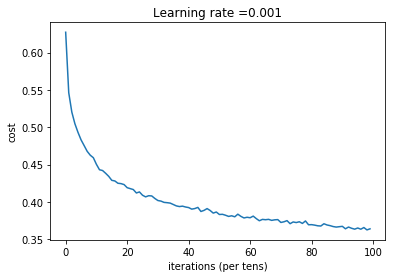

Parameters have been trained!

Train Accuracy: 0.83358335
Test Accuracy: 0.7823333

True negatives: 1249.0
False negatives: 413.0
False positives: 240.0
True positives: 1098.0

Train Precision: 0.8742553
Test Precision: 0.8206278
Train Recall: 0.77490026
Test Recall: 0.7266711

Test accuracy on incompletes: 0.838818



In [29]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [30]:
print(str(len(pred_incomplete)) + " orders predicted to be incomplete are:\n" + str(pred_incomplete))

233 orders predicted to be incomplete are:
['A-372623-2345', 'A-379095-2528', 'D-401602-123669', 'D-401760-65288', 'A-377530-2345', 'D-401721-1376', 'D-401011-198509', 'D-401307-75638', 'D-401441-76877', 'D-399201-198509', 'A-399458-126763', 'D-401376-143544', 'D-399972-17256', 'D-399869-0595', 'D-401540-0649', 'D-401706-0975', 'D-400701-49086', 'D-401654-143544', 'D-401525-143544', 'D-400787-55872', 'D-400529-19753', 'A-399876-4356', 'D-401800-0706', 'D-400970-0803', 'D-401670-0975', 'D-401182-18013', 'D-401453-2526', 'D-400897-76393', 'D-401790-17674', 'D-401421-99724', 'D-401457-17674', 'D-401737-0595', 'D-401009-1909', 'A-381234-2528', 'D-401246-65288', 'D-401466-2526', 'D-398709-76347', 'D-400381-0751', 'D-401495-143544', 'D-394484-4964', 'D-399189-65591', 'D-401177-0595', 'D-400802-0975', 'D-397180-2284', 'D-401325-143544', 'D-399435-76347', 'D-401795-58479', 'D-401108-99777', 'D-401541-49086', 'D-397746-12983', 'D-401419-46349', 'A-401206-0181', 'D-401770-86462', 'A-401809-12676